In [49]:
%matplotlib widget
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def json_fn_to_dict(fn):
    with open(fn, "r") as f:
        d = json.load(f)

    d["log_name"] = fn.stem
    d["x"] = pd.to_datetime(d["x"])    

    return d

def calc_core_corrected_time_to_fit(d):

    model_type = d["model"][0]
    time_to_fit = d["time_to_fit"][0]

    core_corrected_time_to_fit = ...
    if model_type == "CustomLSTM":
        core_corrected_time_to_fit = time_to_fit * 5.5  # experiments showed that LSTM used approximately 550% cores 

    elif model_type == "CustomRandomForest":
        core_corrected_time_to_fit = time_to_fit * 6.5 

    elif model_type == "CustomSARIMAX":

        dt_str_format = "'%a %b %d %H:%M:%S %Y'"
        time_of_start = d['time_before_fit'][0]
        time_of_start = datetime.datetime.strptime(time_of_start, dt_str_format)

        time_when_n_cores_changed = datetime.datetime(2022, 11, 18, 9, 10)

        if time_of_start < time_when_n_cores_changed:
            core_corrected_time_to_fit = time_to_fit * 16.5

        else:
            core_corrected_time_to_fit = time_to_fit * 39.5

    elif model_type == "CustomProphet":
        core_corrected_time_to_fit = time_to_fit * 1.5 

    elif model_type == "":
        ...

    else:
        raise NotImplementedError(f"Error! {model_type} is not implemented")

    d["core_corrected_time_to_fit"] = [core_corrected_time_to_fit]

    return d

def add_metric(d, metric_name, metric_func):
    y, yhat = d["y"][0], d["yhat"][0]

    train_y, train_yhat = d["train_y"][0], d["train_yhat"][0]
    test_y, test_yhat = d["test_y"][0], d["test_yhat"][0]

    d[f"{metric_name}"] = [metric_func(y, yhat)]
    d[f"{metric_name}_train"] = [metric_func(train_y, train_yhat)]
    d[f"{metric_name}_test"] = [metric_func(test_y, test_yhat)]

    return d

def add_split_train_eval(d):
    x, y, yhat = d["x"][0], d["y"][0], d["yhat"][0]
    # assert len(y) == len(yhat)
    n = int(len(y)*d['train_eval_split'][0])

    train_x, train_y, train_yhat = x[:n], y[:n], yhat[:n]
    test_x, test_y, test_yhat = x[n:], y[n:], yhat[n:]

    train_y = [float(_y) for _y in train_y]
    train_yhat = [float(_y) for _y in train_yhat]
    test_y = [float(_y) for _y in test_y]
    test_yhat = [float(_y) for _y in test_yhat]

    d["train_x"] = [train_x]
    d["train_y"] = [train_y]
    d["train_yhat"] = [train_yhat]

    d["test_x"] = [test_x]
    d["test_y"] = [test_y]
    d["test_yhat"] = [test_yhat]

    return d

def add_metrics(d):
    d = add_metric(d, metric_name="r2", metric_func=r2_score)
    d = add_metric(d, metric_name="mse", metric_func=mean_squared_error)
    d = add_metric(d, metric_name="mae", metric_func=mean_absolute_error)
    d = add_metric(d, metric_name="mape", metric_func=mean_absolute_percentage_error)

    return d
  
def add_binary_classification(d):
    trained_on = d["trained_on"][0]

    if "industrial" in trained_on:
        classification = "industrial"
    elif "residential" in trained_on:
        classification = "residential"

    else:
        raise NotImplementedError(f"trained_on = {trained_on}")

    d["binary_classification"] = [classification]
    return d

def add_trinary_classification(d):
    trained_on = d["trained_on"][0]

    if "industrial" in trained_on:
        classification = "industrial"
    elif "NO_PV" in trained_on:
        classification = "NO_PV"
    elif "WITH_PV" in trained_on:
        classification = 'WITH_PV'
    else:
        raise NotImplementedError(f"trained_on = {trained_on}")

    d["trinary_classification"] = [classification]
    return d
    
def prep_dict(d):
    d = {k: [v] for k, v in d.items()}

    d["trained_on"] = [Path(d["data_source_path"][0]).stem]

    d["log_ID"] = [int(d["log_name"][0].split("_")[0])]

    d = add_file_end(d)

    d = add_horizon(d)

    d = add_binary_classification(d)

    d = add_trinary_classification(d)

    d = calc_core_corrected_time_to_fit(d)

    d = add_split_train_eval(d)
    
    d = add_metrics(d)

    return d

def add_horizon(d):
    x = d["trained_on"][0] #  x = 'h=4_industrial_2016_LG_4'
    
    x = x.split("_")[0] # x = "h=4"

    x = x[2:]  # x = "4"

    x = int(x)

    d["horizon"] = [x]

    return d

def add_file_end(d):
    trained_on = d["trained_on"][0]

    foo = trained_on.split("_")

    foo = ("_").join(foo[1:])

    d["file_end"] = [foo]

    return d


def lazy_prep_dict(fn):
    d = json_fn_to_dict(fn)
    d = prep_dict(d)

    return d


def dicts_to_df(dicts):
    df = pd.DataFrame(dicts[0])

    for d in dicts[1:]:
        # make the new dataframe
        new_df = pd.DataFrame(d)

        # if not all columns of the new df are in the old df:
        for c in new_df.columns:
            if c not in df.columns:
                df[c] = [np.nan]*len(df)

        # if not all columns of the old df are in the new df:
        for c in df.columns:
            if c not in new_df.columns:
                new_df[c] = [np.nan]

        assert all(c in new_df.columns for c in df)
        assert all(c in df.columns for c in new_df)

        df = pd.concat([df, new_df], ignore_index=True)

    return df

In [50]:
log_dir = Path(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\00_Programming\forecasting\logs")
fns = [fn for fn in log_dir.iterdir() if fn.is_file()]
# fns = [fn for fn in fns if int(fn.stem.split("_")[0]) >= 196]


In [51]:
ds = [lazy_prep_dict(fn) for fn in fns]
full_df = dicts_to_df(ds)
full_df.shape


C:\Users\Flin\AppData\Local\Temp\ipykernel_3224\3492674987.py:205: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df, new_df], ignore_index=True)


(509, 57)

In [4]:
full_df.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'weekly_seasonality', 'daily_seasonality',
       'only_fit_using_last_n_weeks', 'rolling_predict_rows_to_refit',
       'n_cores', 'rolling_prediction', 'tiny_test', 'os', 'time_at_saving',
       'log_name', 'trained_on', 'log_ID', 'binary_classification',
       'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
       'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'r2',
       'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
       'n_estimators', 'ts2row_history_window', 'n_train_epochs',
       'learning_rate', 'learning_rate_scheduler_enabled',
       'learning_rate_decay_factor', 'window_size', 'swa_enabled', 'swa_start',
       'SARIMAX_max_iter', 'SARIMAX_order', 'SARIMAX_seasonal_order'],
      dtype='object'

# Analyze

## Qualitative analysis
- plot the performance if several agents in exactly the same file
- Study the performance

In [54]:
filenames = ["h=1_industrial_2016_LG_8",
"h=1_residential_2018_NO_PV_SFH9_2018",
"h=1_residential_2019_WITH_PV_SFH15_2018",
"h=12_industrial_2016_LG_18",
"h=12_residential_2018_NO_PV_SFH17_2018",
"h=12_residential_2019_WITH_PV_SFH15_2019"]

columns_of_interest = ["x", "y", "yhat", "time_to_predict", "model", 'core_corrected_time_to_fit', 'r2', 'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test', "train_eval_split"]
       
fn = filenames[0]

In [55]:
#df = full_df[full_df["trained_on"]==fn]
model_df = full_df[full_df["model"].isin(["CustomRandomForest", "CustomProphet", "CustomLSTM"])]
model_df.shape

(462, 57)

In [58]:
model_df.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'weekly_seasonality', 'daily_seasonality',
       'only_fit_using_last_n_weeks', 'rolling_predict_rows_to_refit',
       'n_cores', 'rolling_prediction', 'tiny_test', 'os', 'time_at_saving',
       'log_name', 'trained_on', 'log_ID', 'file_end', 'binary_classification',
       'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
       'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'r2',
       'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
       'n_estimators', 'ts2row_history_window', 'n_train_epochs',
       'learning_rate', 'learning_rate_scheduler_enabled',
       'learning_rate_decay_factor', 'window_size', 'swa_enabled', 'swa_start',
       'SARIMAX_max_iter', 'SARIMAX_order', 'SARIMAX_seasonal_order'],
      dt

In [7]:
def add_limits(ax, train_x, test_x, only_show_test_results, remove_last_n_days=0, only_show_last_n_days=0):
    if only_show_last_n_days and only_show_last_n_days:
        print("Both 'only_show_last_n_days' and 'only_show_last_n_days' are used, defaulting to 'only_show_last_n_days'")

    x = [x for x in train_x] + [x for x in test_x]
    td = (x[1] - x[0]).total_seconds()

    if remove_last_n_days:
        remove_last_n_rows = int(remove_last_n_days*24*3600 / td)

        if remove_last_n_rows > len(x):
            print("IGNORING remove_last_n_rows, since: 'remove_last_n_rows) > len(x)'") 

        else:
            x = x[-remove_last_n_rows:]

    if only_show_last_n_days:
        show_last_n_rows = int(only_show_last_n_days*24*3600 / td)
        x = x[-show_last_n_rows:]

    if only_show_test_results:
        if len(x) < len(train_x):
            print("IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already")
        else:
            x = x[len(train_x):]

    ax.set_xlim([x[0], x[-1]])
    return ax


def draw_x_and_y(ax, dic, title_prefix=None, only_show_last_n_weeks=0):
    train_x, test_x = dic["train_x"], dic["test_x"]
    #train_x, test_x = pd.to_datetime(train_x), pd.to_datetime(test_x)

    train_y, test_y = dic["train_y"], dic["test_y"]
    train_yhat, test_yhat = dic["train_yhat"], dic["test_yhat"]

    model = dic["model"]
    if model.startswith("Custom"):
        model = model[6:]

    ax.plot(train_x, train_y, color="blue", label="y")
    ax.plot(train_x, train_yhat, color="red", label="yhat")

    ax.plot(test_x, test_y, color="blue")
    ax.plot(test_x, test_yhat, color="red")

    ax.vlines(test_x[0], min(min(train_y), min(test_y)), max(max(train_y), max(test_y)), color="black")

    ax = add_limits(ax, train_x, test_x, only_show_test_results=True, remove_last_n_days=7, only_show_last_n_days=0)



    if title_prefix is None:
        title = model
    else:
        title = f"{title_prefix}_{model}"


    ax.set_title(title)
    ax.grid()
    ax.legend()

    return ax

def draw_error(ax, dic, title_prefix=None, only_show_last_n_weeks=0):
    train_x, test_x = dic["train_x"], dic["test_x"]
    #train_x, test_x = pd.to_datetime(train_x), pd.to_datetime(test_x)

    train_y, test_y = dic["train_y"], dic["test_y"]
    train_yhat, test_yhat = dic["train_yhat"], dic["test_yhat"]

    model = dic["model"]
    if model.startswith("Custom"):
        model = model[6:]

    assert len(train_y) == len(train_yhat)
    train_error = [_y - _yh for _y, _yh in zip(train_y, train_yhat)]

    assert len(test_y) == len(test_yhat)
    test_error = [_y - _yh for _y, _yh in zip(test_y, test_yhat)]
    

    ax.plot(train_x, train_error, color="red", label="y-yhat")
    ax.plot(test_x, test_error, color="red")

    ax = add_limits(ax, train_x, test_x, only_show_test_results=True, remove_last_n_days=7, only_show_last_n_days=0)


    if title_prefix is None:
        title = model
    else:
        title = f"{title_prefix}_{model}"

    ax.set_title(title)
    ax.grid()
    ax.legend()

    return ax

IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already
IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already
IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already
IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already
IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already
IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already


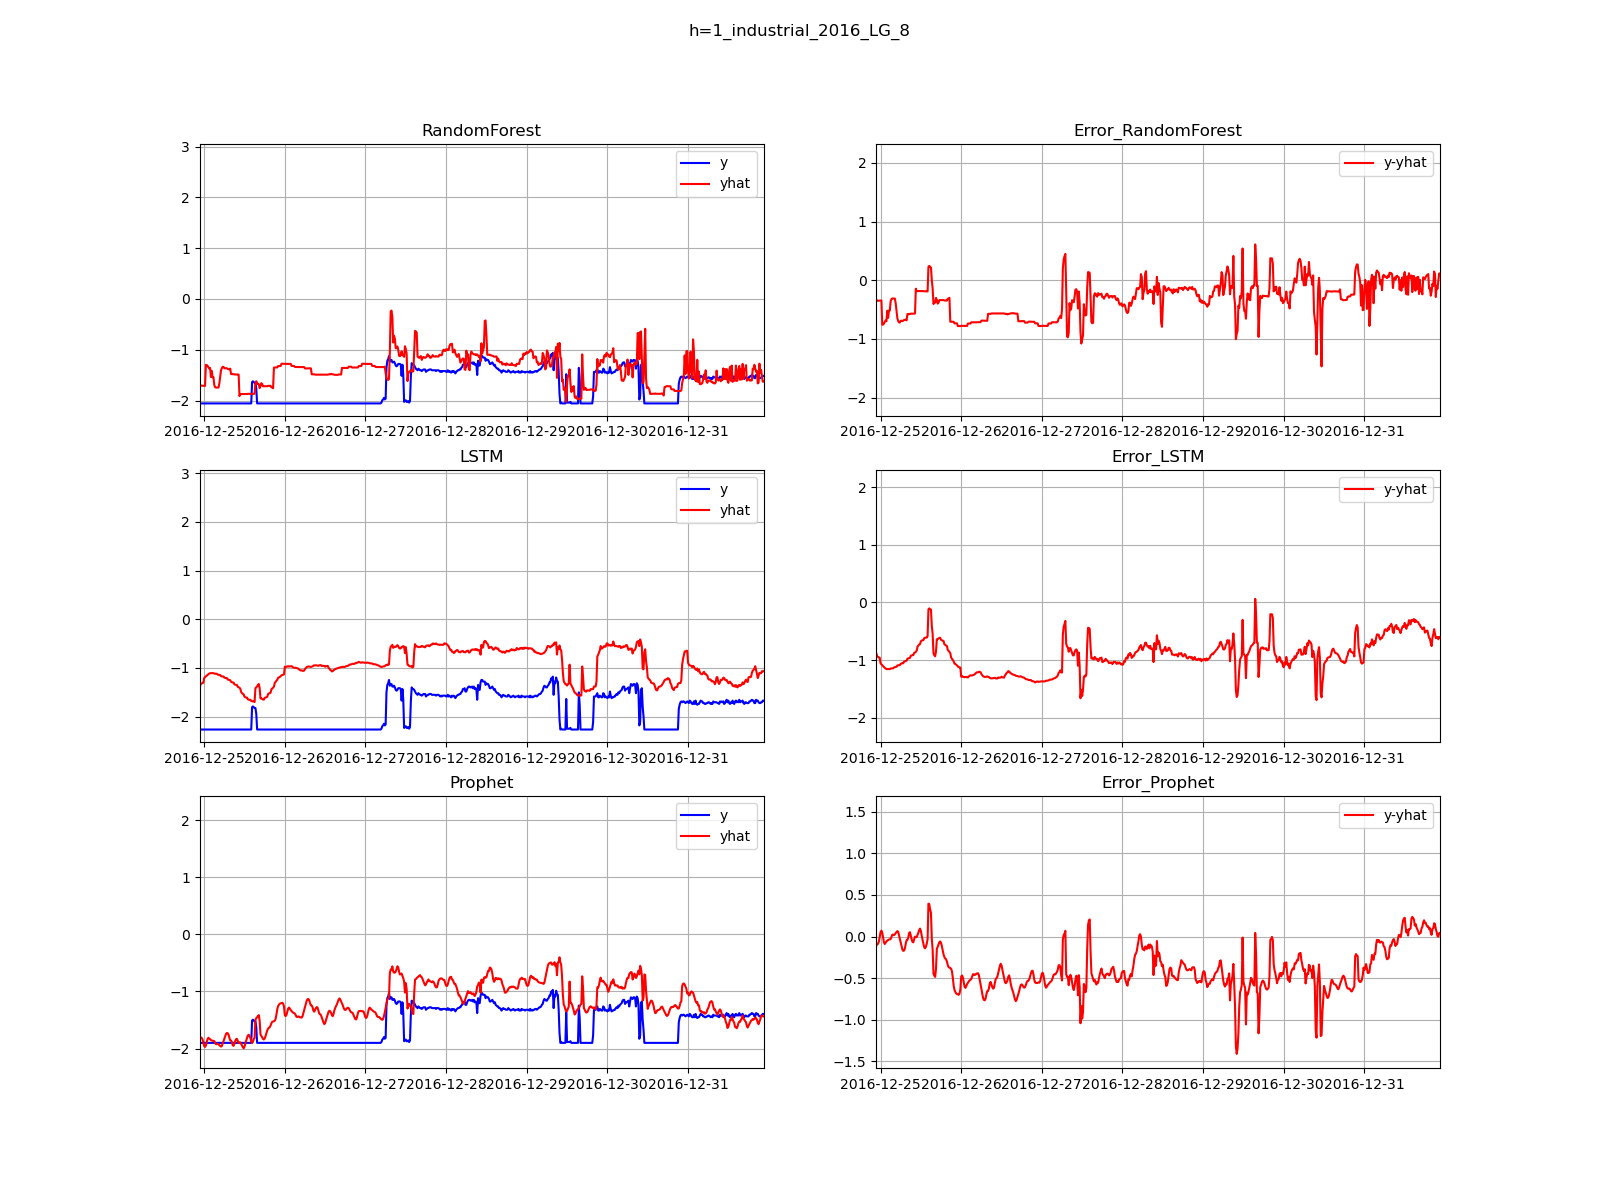

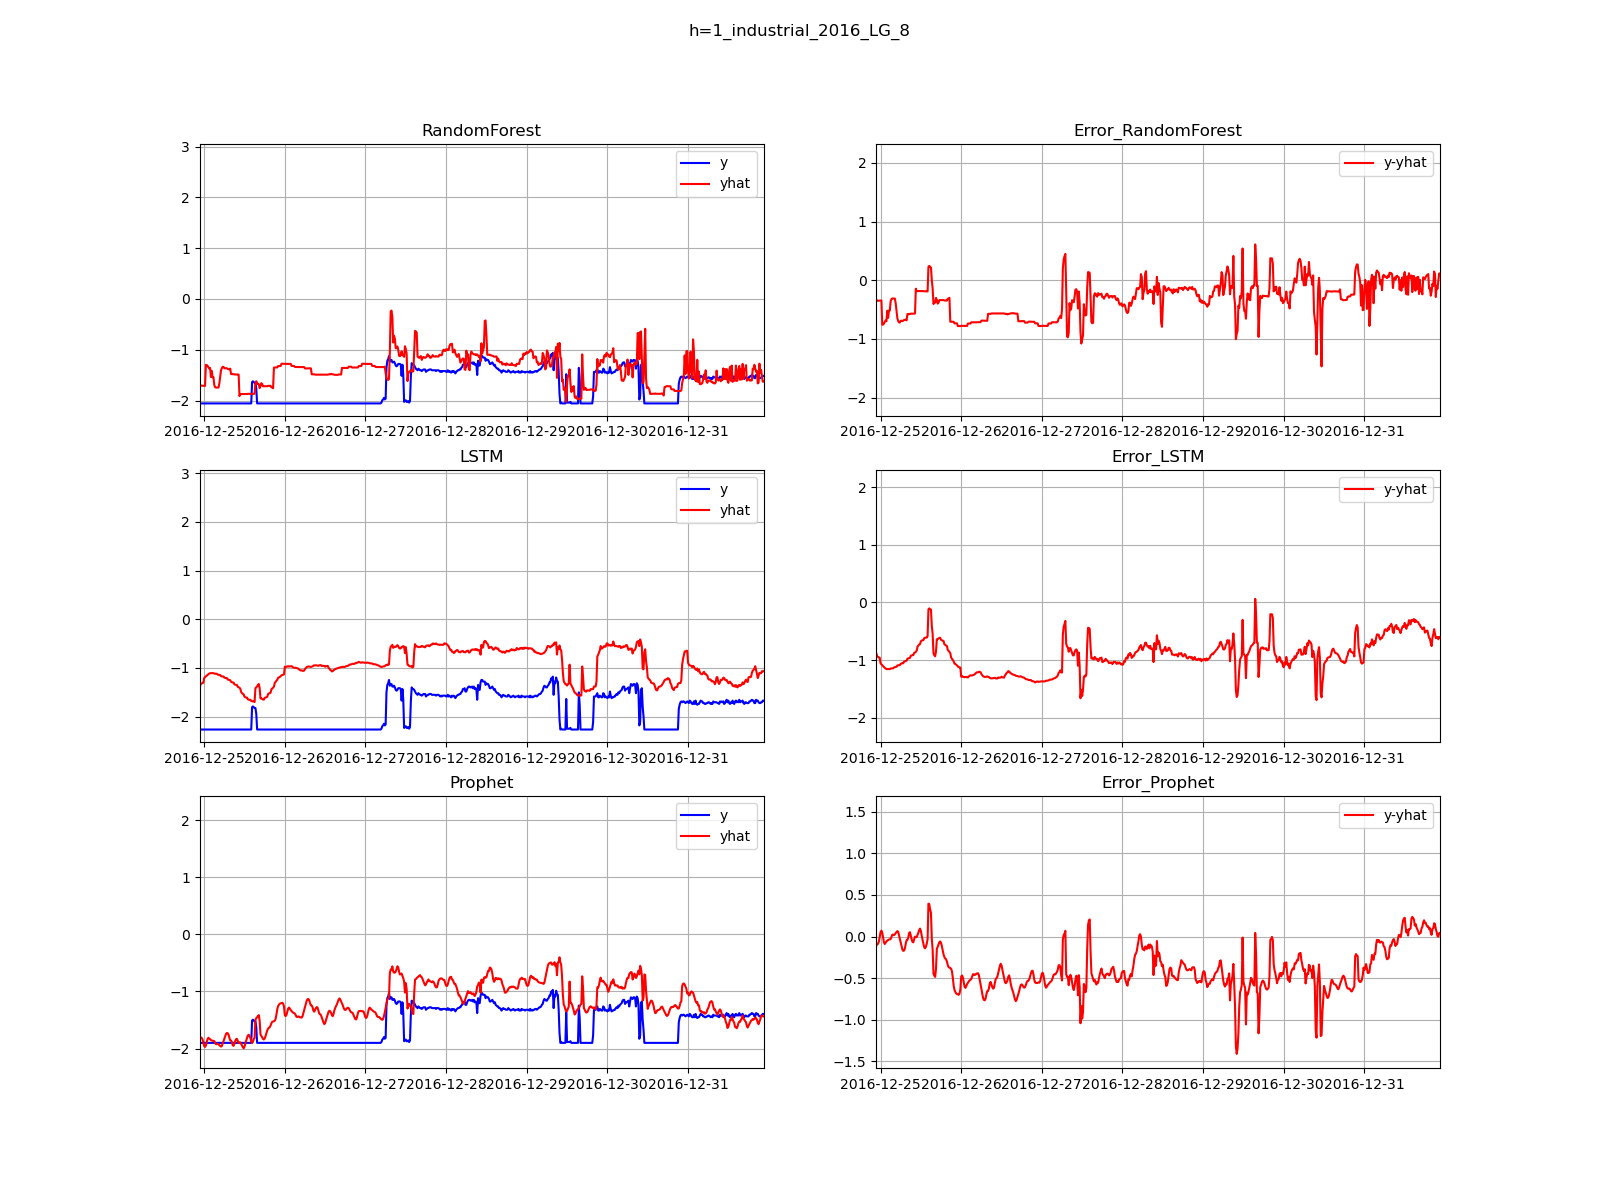

In [8]:
for fn in filenames:
    sub_df = model_df[model_df["trained_on"]==fn]

    n = sub_df.shape[0]

    if n == 0:
        print(f"Skipping {fn}")
        continue

    fig, axs = plt.subplots(n, 2, figsize=(16, 12))
    fig.suptitle(fn)

    for i, (idx, row) in enumerate(sub_df.iterrows()):
        axs[i, 0] = draw_x_and_y(axs[i, 0], dict(row), only_show_last_n_weeks=6)
        axs[i, 1] = draw_error(axs[i, 1], dict(row), title_prefix="Error", only_show_last_n_weeks=6)

    fig.show()
    break

    

In [9]:
filenames

['h=1_industrial_2016_LG_8',
 'h=1_residential_2018_NO_PV_SFH9_2018',
 'h=1_residential_2019_WITH_PV_SFH15_2018',
 'h=12_industrial_2016_LG_18',
 'h=12_residential_2018_NO_PV_SFH17_2018',
 'h=12_residential_2019_WITH_PV_SFH15_2019']

Skipping h=1_residential_2019_WITH_PV_SFH15_2018


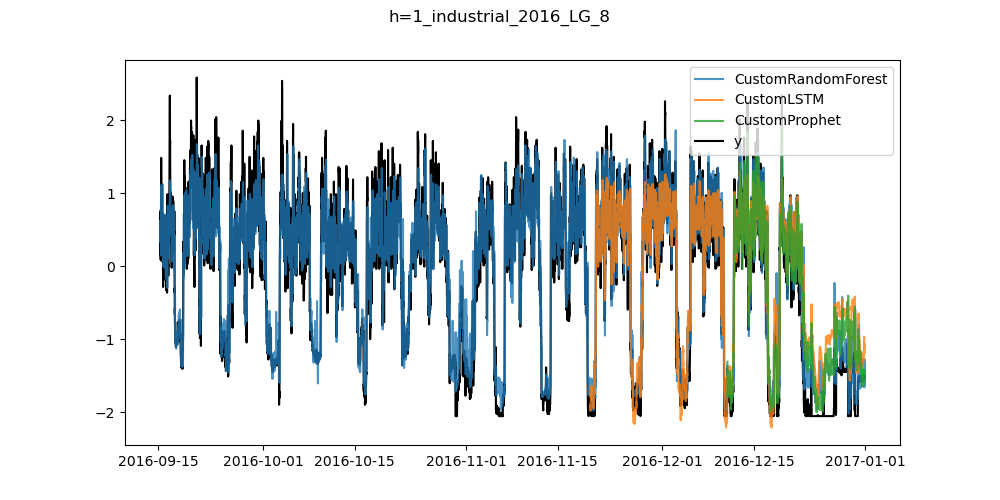

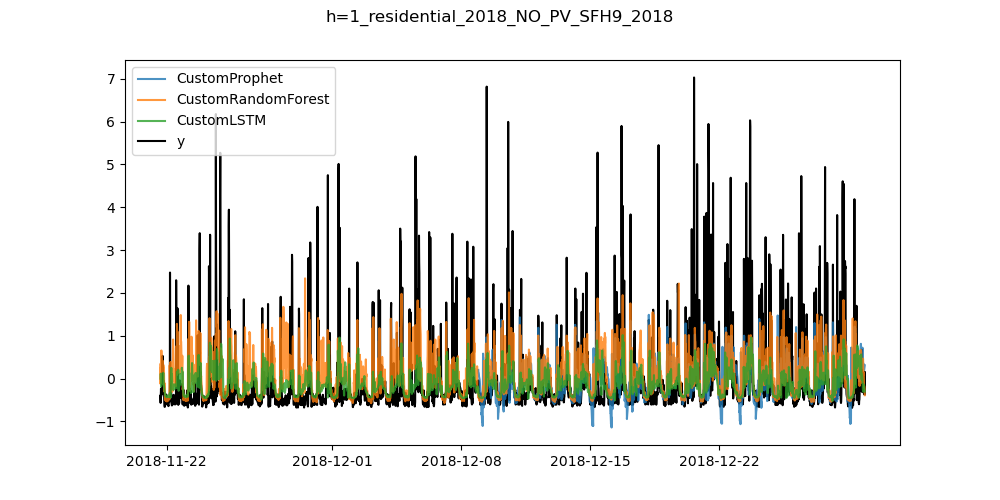

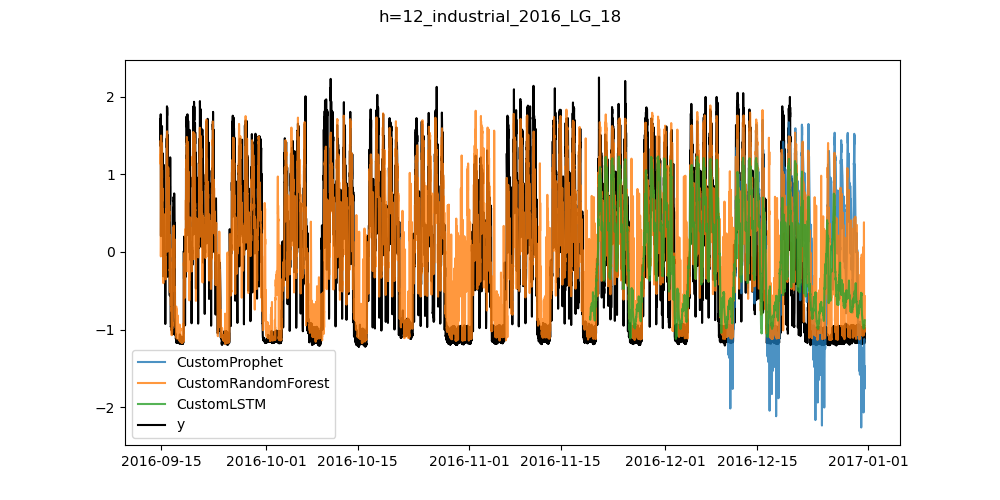

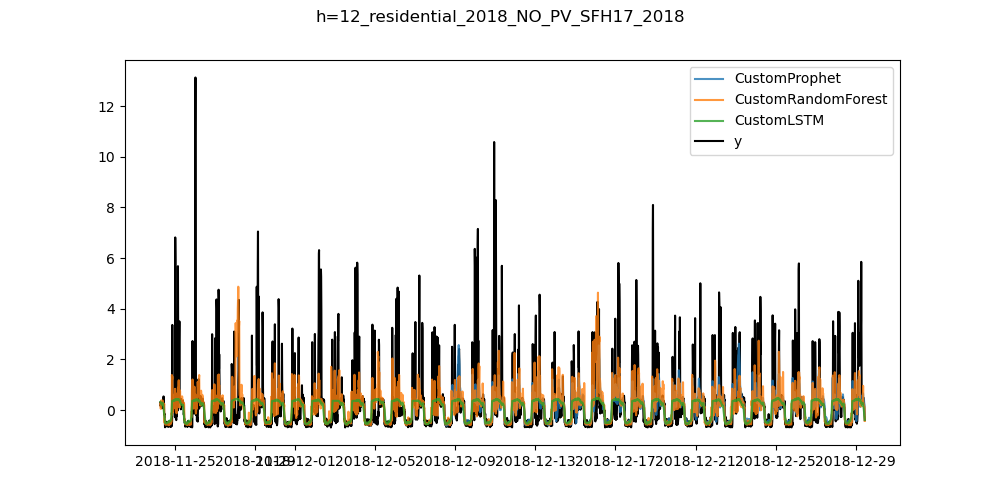

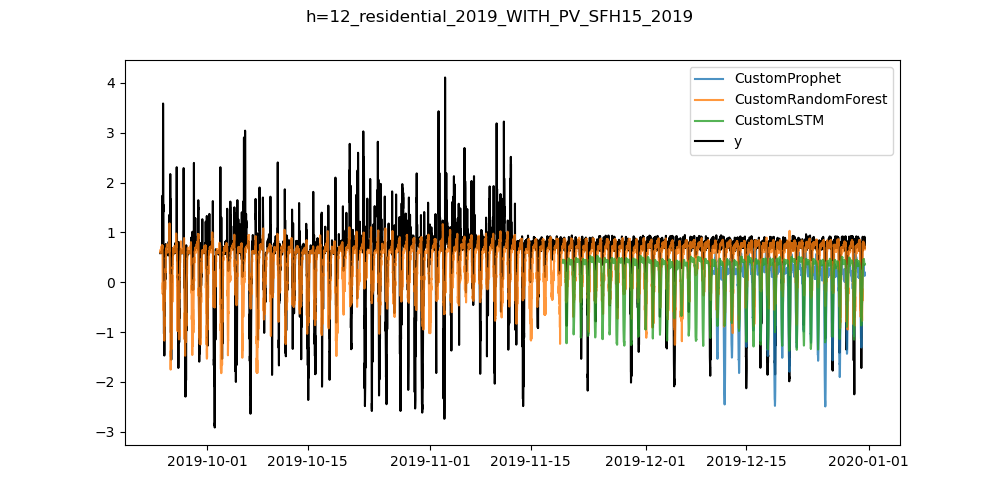

In [16]:

for fn in filenames:
    longest_y = []

    sub_df = model_df[model_df["trained_on"]==fn]

    n = sub_df.shape[0]

    if n == 0:
        print(f"Skipping {fn}")
        continue

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(fn)


    for i, (idx, row) in enumerate(sub_df.iterrows()):
        model = row["model"]
        x = row["test_x"]
        yhat = row["test_yhat"]

        ax.plot(x, yhat, label=model, alpha=0.8)


        y = list(row["test_y"])

        if len(y) > len(longest_y):
            longest_x = x
            longest_y = y

    ax.plot(longest_x, longest_y, label="y", color="black", zorder=0)

    # 
    ax.set_xlim()

    ax.legend()




In [ ]:
sub_df

## Quantitative analysis
- plot heatmap of [fn]x[model], for each metric, at each horizon
- Plot degradation of metric over horizon

In [13]:
import seaborn as sns

In [ ]:
drop_SARIMAX = True
pivot_table = False


for metric in ["r2_test", "mse_test", "mae_test", "mape_test", 'core_corrected_time_to_fit']:
    row_index = "trained_on"
    col_index = "model"

    if pivot_table:
        table = pd.pivot_table(model_df, values=metric, index=[row_index], columns=[col_index])

    else:
        table = model_df
    

    if drop_SARIMAX:
        if "CustomSARIMAX" in table.columns:
            table = table.drop(columns="CustomSARIMAX")

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(metric)
    if pivot_table:
        ax = sns.boxplot(table, ax=ax)
    else:
        ax = sns.boxplot(data=table, x="model", y=metric, hue="trinary_classification")
    
    ax.grid()


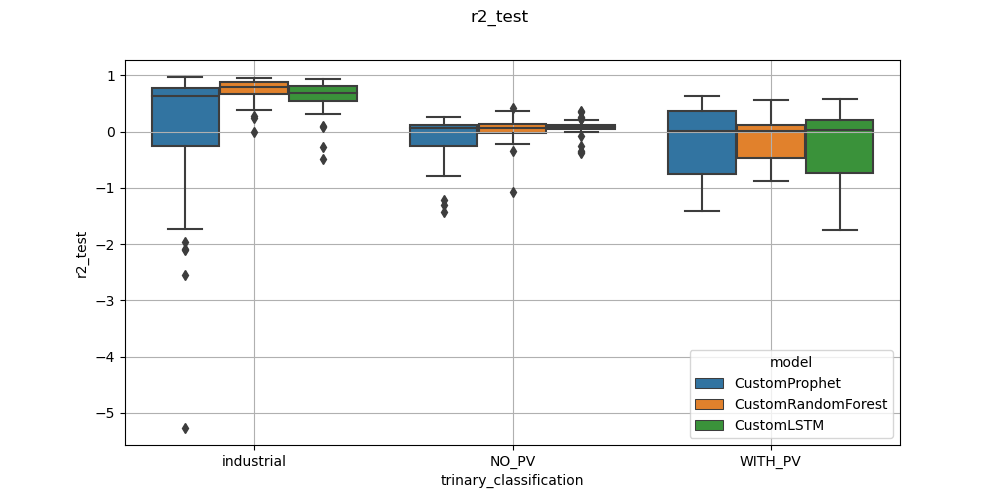

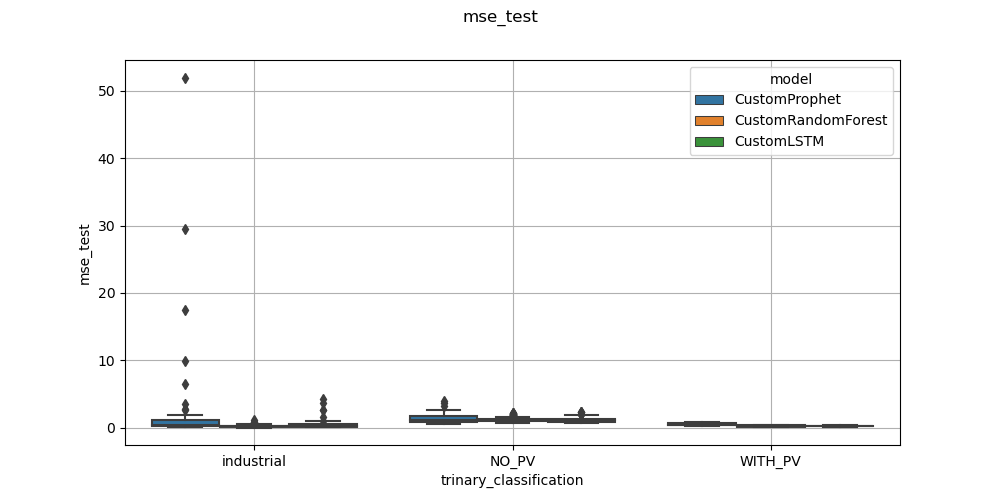

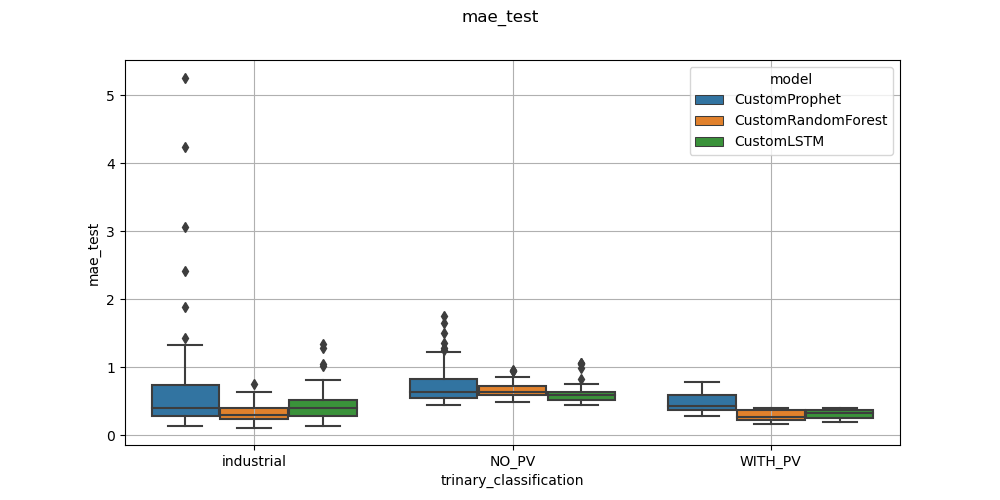

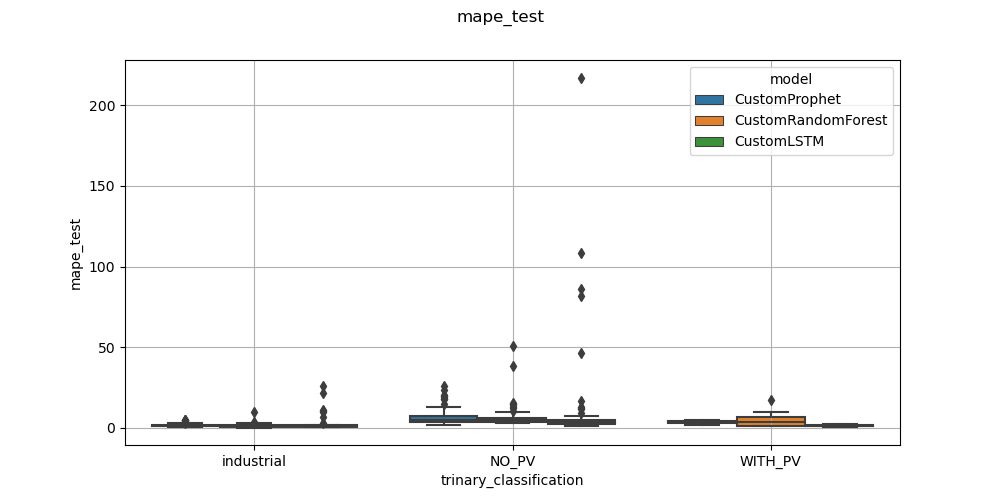

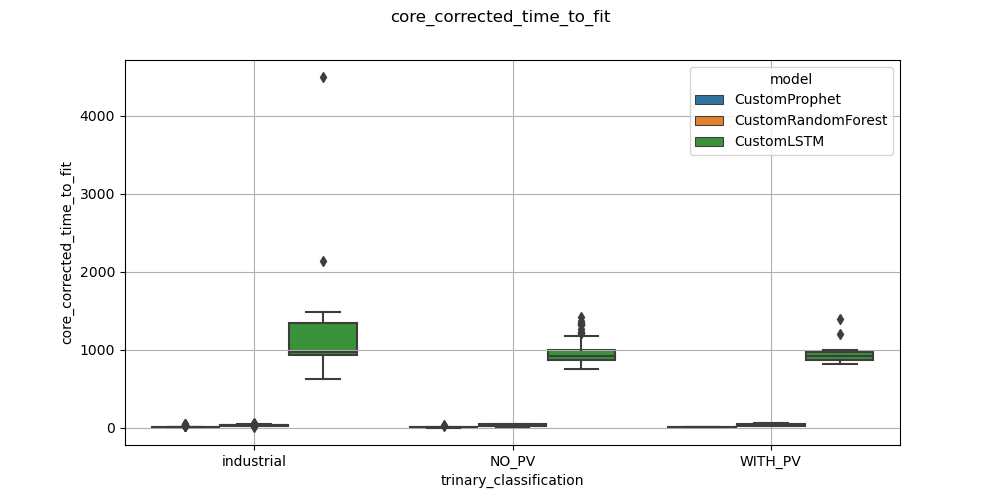

In [14]:
drop_SARIMAX = True
pivot_table = False


for metric in ["r2_test", "mse_test", "mae_test", "mape_test", 'core_corrected_time_to_fit']:
    row_index = "trained_on"
    col_index = "model"

    if pivot_table:
        table = pd.pivot_table(model_df, values=metric, index=[row_index], columns=[col_index])

    else:
        table = model_df
    

    if drop_SARIMAX:
        if "CustomSARIMAX" in table.columns:
            table = table.drop(columns="CustomSARIMAX")

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(metric)
    if pivot_table:
        ax = sns.boxplot(table, ax=ax)
    else:
        ax = sns.boxplot(data=table, x="trinary_classification", y=metric, hue="model")
    
    ax.grid()


In [ ]:
drop_SARIMAX = True
pivot_table = False


for metric in ["r2_test", "mse_test", "mae_test", "mape_test", 'core_corrected_time_to_fit']:
    row_index = "trained_on"
    col_index = "model"

    if pivot_table:
        table = pd.pivot_table(model_df, values=metric, index=[row_index], columns=[col_index])

    else:
        table = model_df
    

    if drop_SARIMAX:
        if "CustomSARIMAX" in table.columns:
            table = table.drop(columns="CustomSARIMAX")

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(metric)
    if pivot_table:
        ax = sns.violinplot(table, ax=ax)
    else:
        ax = sns.violinplot(data=table, x="trinary_classification", y=metric, hue="model")
    
    ax.grid()

In [ ]:
drop_SARIMAX = False

#context = {"r2_test": [-3, 2], "mse_test": [-2, 5], "mae_test": [-1, 2.5], "mape_test": [0, 40], 'core_corrected_time_to_fit':None}
context = {"r2_test": None, "mse_test": None, "mae_test": None, "mape_test": None, 'core_corrected_time_to_fit': None}

for metric, ylim in context.items():
    row_index = "trained_on"
    col_index = "model"

    table = pd.pivot_table(model_df, values=metric, index=[row_index], columns=[col_index])

    if drop_SARIMAX:
        if "CustomSARIMAX" in table.columns:
            table = table.drop(columns="CustomSARIMAX")

    fig, ax = plt.subplots(figsize=(10, 10))
    
    if ylim is not None:
        ax.set_ylim(ylim)

    fig.suptitle(metric)
    ax = sns.violinplot(table, ax=ax)

## Performance over horizon

In [17]:
full_df["model"].unique()

array(['CustomProphet', 'CustomRandomForest', 'CustomLSTM',
       'CustomSARIMAX'], dtype=object)

In [57]:
model_df.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'weekly_seasonality', 'daily_seasonality',
       'only_fit_using_last_n_weeks', 'rolling_predict_rows_to_refit',
       'n_cores', 'rolling_prediction', 'tiny_test', 'os', 'time_at_saving',
       'log_name', 'trained_on', 'log_ID', 'file_end', 'binary_classification',
       'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
       'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'r2',
       'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
       'n_estimators', 'ts2row_history_window', 'n_train_epochs',
       'learning_rate', 'learning_rate_scheduler_enabled',
       'learning_rate_decay_factor', 'window_size', 'swa_enabled', 'swa_start',
       'SARIMAX_max_iter', 'SARIMAX_order', 'SARIMAX_seasonal_order'],
      dt

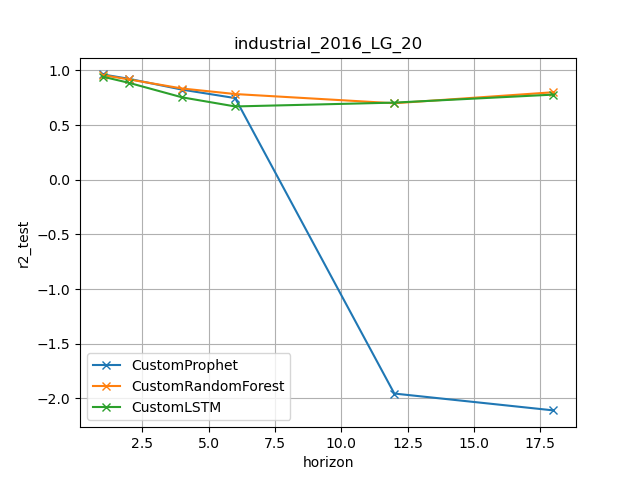

In [63]:
models = list(model_df["model"].unique())
file_endings = list(model_df["file_end"].unique())
metric = "r2_test"

for file_end in file_endings:
    file_df = model_df[model_df["file_end"]==file_end]

    fig, ax = plt.subplots()

    for model in models:
        model_file_df = file_df[file_df["model"] == model]

        horizon_metric_list = [[r["horizon"], r[metric]] for _, r in model_file_df.iterrows()]
        horizon_metric_list.sort(key = lambda x: x[0])

        x = [x[0] for x in horizon_metric_list]
        y = [x[1] for x in horizon_metric_list]

        ax.plot(x, y, marker="x", label=model)
    
    ax.legend()
    ax.grid()
    ax.set_title(file_end)
    ax.set_xlabel("horizon")
    ax.set_ylabel(metric)

    break


In [72]:
cols = model_df.columns
metrics = [c for c in cols if c.endswith("test")]
metrics

['tiny_test', 'r2_test', 'mse_test', 'mae_test', 'mape_test']

In [75]:
horizons

[1, 2, 4, 6, 12, 18]

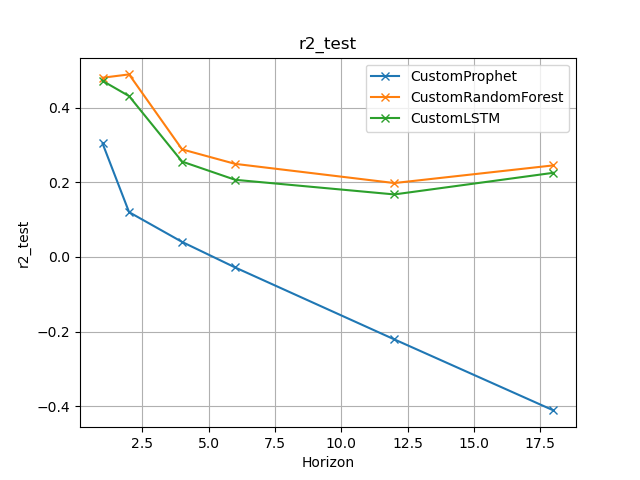

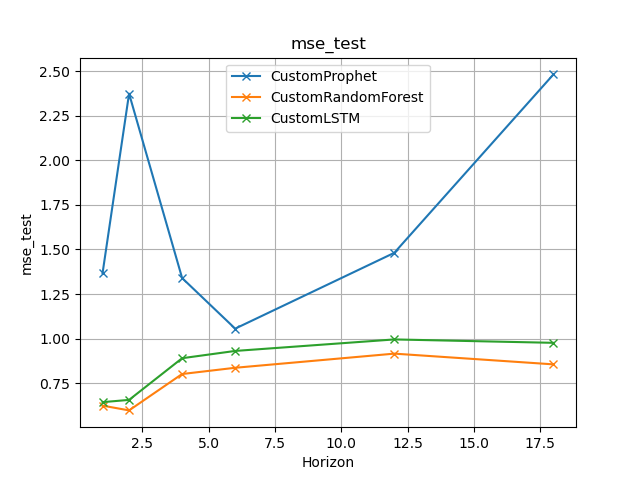

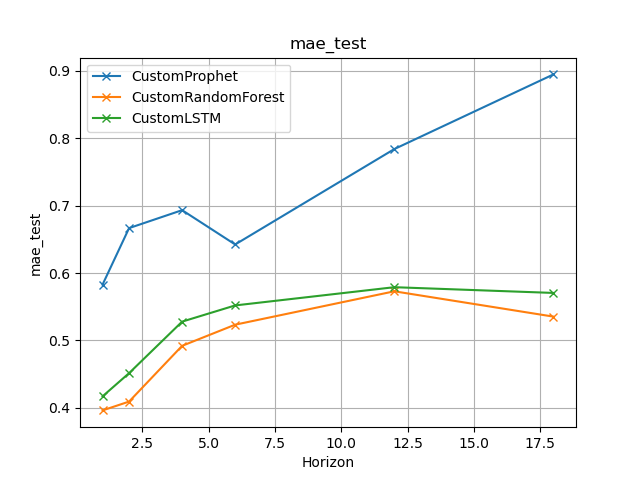

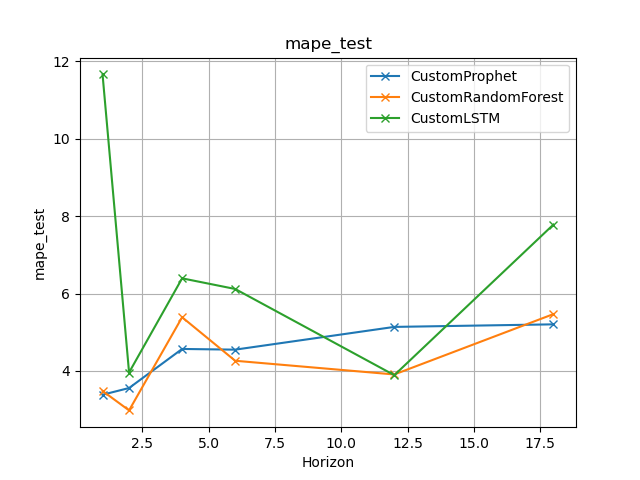

In [86]:
models = list(model_df["model"].unique())
file_endings = list(model_df["file_end"].unique())
horizons = list(model_df["horizon"].unique())
horizons.sort()
metrics = ['r2_test', 'mse_test', 'mae_test', 'mape_test']

complete_dict = {}


for metric in metrics:

    
    model_horizon_metric_dict = {m: {} for m in models}
    
    for horizon in horizons:
        horizon_df = model_df[model_df["horizon"] == horizon]

        for model in models:
            model_horizon_df = horizon_df[horizon_df["model"]==model]
            values = list(model_horizon_df[metric].values)
            
            if len(values) == 0:
                print(f"Skipping {model}, h={horizon}")
                continue

            mean = sum(values)/len(values)

            model_horizon_metric_dict[model][horizon] = mean

    fig, ax = plt.subplots()

    for m, values in model_horizon_metric_dict.items():
        x = list(values.keys())
        y = list(values.values())

        ax.plot(x, y, marker="x", label=m)

    ax.set_title(metric)
    ax.set_xlabel("Horizon")
    ax.set_ylabel(metric)
    ax.grid()
    ax.legend()

    complete_dict[metric] = model_horizon_metric_dict


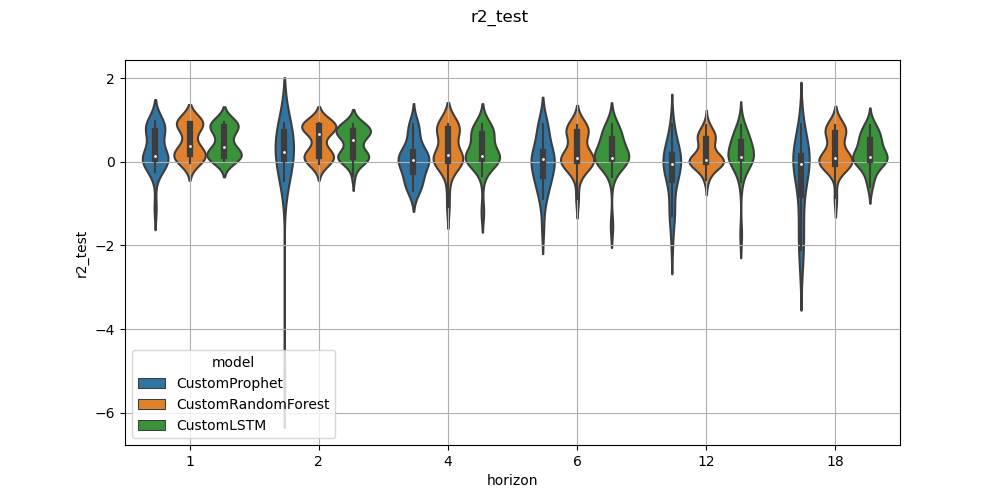

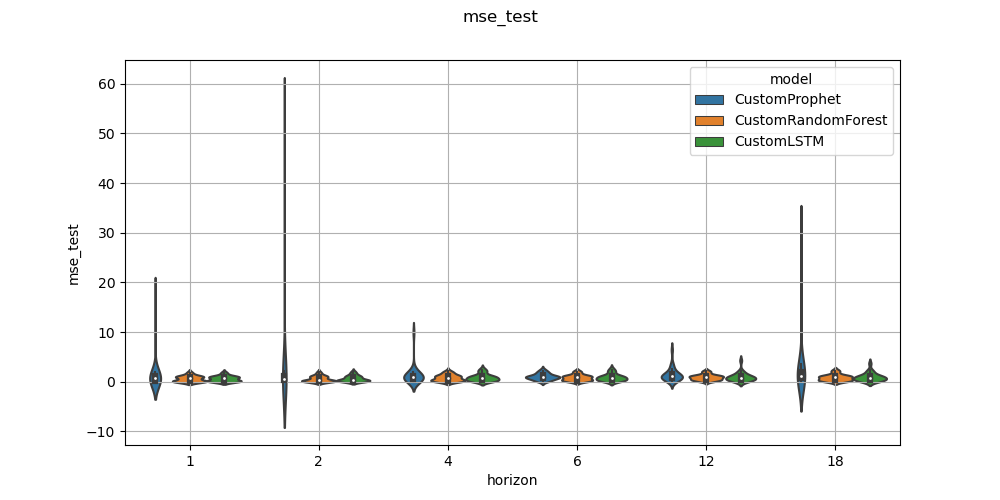

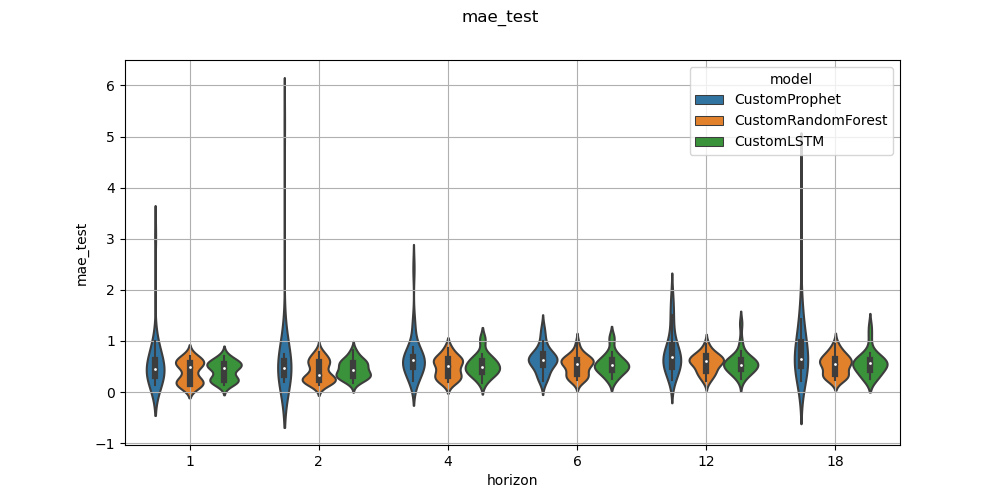

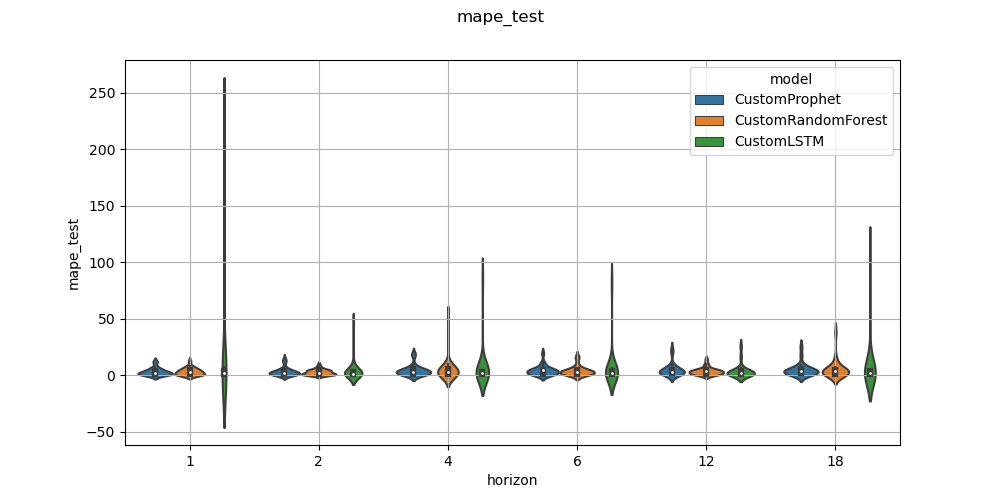

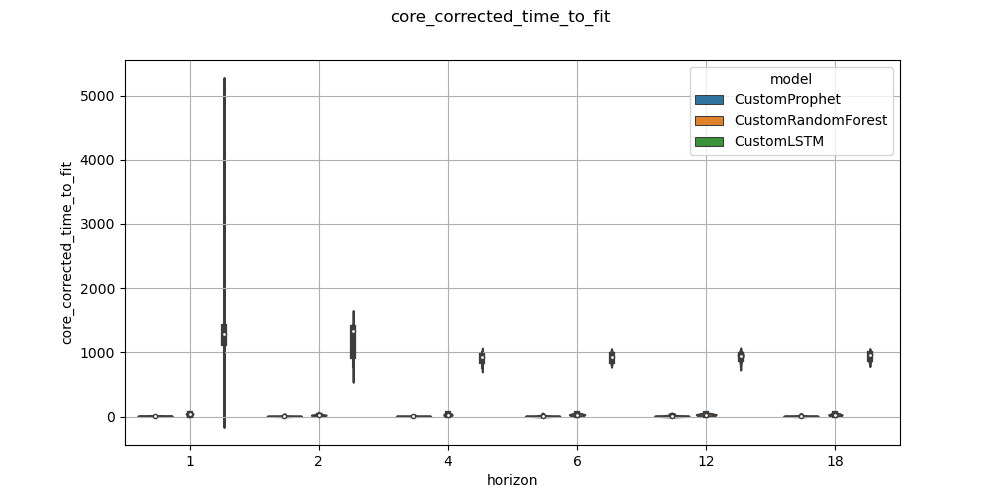

In [52]:



for metric in ["r2_test", "mse_test", "mae_test", "mape_test", 'core_corrected_time_to_fit']:
    row_index = "trained_on"
    col_index = "model"

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(metric)

    ax = sns.violinplot(data=model_df, x="horizon", y=metric, hue="model", order=list(model_df["horizon"].unique()).sort())
    
    ax.grid()

In [77]:
model_horizon_metric_dict

{'CustomProphet': {},
 'CustomRandomForest': {},
 'CustomLSTM': {1: 11.65905862401938,
  2: 3.9597194260021653,
  4: 6.392183928640509,
  6: 6.117304289343019,
  12: 3.8910282624599444,
  18: 7.781974316702911}}